## IMPORT LIBRARIES

In [1]:
# Import pandas for data manipulation and analysis
import pandas as pd 

# Import numpy for numerical operations, especially array manipulation
import numpy as np

# Import seaborn for advanced data visualization
import seaborn as sns

# Import StandardScaler to normalize features (mean = 0, standard deviation = 1)
from sklearn.preprocessing import StandardScaler

# Import train_test_split to split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Import matplotlib for plotting graphs and visualizations
import matplotlib.pyplot as plt

# Import clear_output to refresh output cells in Jupyter during live updates
from IPython.display import clear_output

## IMPORT AND CLEAN DATA

In [2]:
# Import the dataset
data = pd.read_csv("data.csv")

# Drop the 'id' column and the unnamed empty column
data.drop(['Unnamed: 32', 'id'], axis=1, inplace=True)

# Convert the 'diagnosis' column: 'M' (malignant) becomes 1, 'B' (benign) becomes 0
data['diagnosis'] = [1.0 if value == "M" else 0.0 for value in data['diagnosis']]

## PREPARE DATA FOR TRAINING

In [3]:
# Define the target variable
Y = data["diagnosis"]

# Define the feature variables (predictors)
X = data.drop(["diagnosis"], axis=1)

## STANDARDIZE DATA

In [4]:
# Create a StandardScaler object to normalize the features (mean = 0, standard deviation = 1)
scaler = StandardScaler()

# Fit the scaler on X and transform it to a standardized version
X_scaled = scaler.fit_transform(X)

## SPLIT DATA

In [5]:
# Split the data: 70% for training and 30% for testing
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.30, random_state=42)

## UTILITIES

In [6]:
# Define the sigmoid activation function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## PREDICTION

In [7]:
# Define the predict function, which calculates the prediction for a given input example
def predict(weights, bias, input_example):
    # Initialize the weighted sum to 0
    weighted_sum = 0  
    # Loop through each feature to compute the weighted sum
    for current_feature_index in range(weights.shape[0]):
        # Add the product of the current weight and the corresponding input feature
        weighted_sum += weights[current_feature_index] * input_example[current_feature_index]
    # Add the bias term to the weighted sum
    weighted_sum += bias
    # Apply the sigmoid function to the weighted sum to get a probability
    prediction = sigmoid(weighted_sum)
    # Return the final prediction
    return prediction

## COST

In [8]:
# Define the cost function, which calculates the average log loss over all examples
def cost(weights, bias, inputs, expected_outputs):
    # Convert expected_outputs to a numpy array to ensure correct indexing
    expected_outputs = np.array(expected_outputs)
    # Get the number of examples (rows) in the dataset 
    number_of_examples = inputs.shape[0]
    # Initialize the sum of the losses to 0
    sum_loss = 0
    # Loop over each example 
    for i in range(number_of_examples):
        # Get the true label of the current example 
        y_true = expected_outputs[i]
        # Get the predicted probability for the current example
        y_pred = predict(weights, bias, inputs[i])
        # To avoid log(0), clip very small or very large predictions
        if y_pred == 0:
            y_pred = 1e-15  # Set a minimum value close to 0
        elif y_pred == 1:
            y_pred = 1 - 1e-15  # Set a maximum value just below 1
        # Add the log loss for the current example to the total sum
        sum_loss += y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)
    # Compute the average loss
    cost = -sum_loss / number_of_examples
    # Return the final cost value
    return cost

## GRADIENT DESCENT

In [9]:
# Define the function to compute the gradient of the cost function with respect to the weights
def compute_gradient_w(weights, bias, inputs, expected_outputs):
    # Convert expected_outputs to a numpy array
    expected_outputs = np.array(expected_outputs)
    # Get the number of examples (rows) in the dataset
    number_of_examples = inputs.shape[0]
    # Get the number of features (columns) in the dataset
    number_of_features = inputs.shape[1]
    # Initialize the gradient for weights as a vector of zeros (same shape as weights)
    gradient_w = np.zeros_like(weights)
    # Loop over each training example 
    for i in range(number_of_examples):
        # Predict the probability for the current example
        y_pred = predict(weights, bias, inputs[i])
        # Get the true label for the current example
        y_true = expected_outputs[i]
        # Loop over each feature
        for j in range(number_of_features):
            # Accumulate the gradient: (prediction error) * (feature value)
            gradient_w[j] += (y_pred - y_true) * inputs[i][j]
    # Average the gradient over all examples
    gradient_w = gradient_w / number_of_examples
    # Return the computed gradient for the weights
    return gradient_w

# Define the function to compute the gradient of the cost function with respect to the bias
def compute_gradient_b(weights, bias, inputs, expected_outputs):
    # Convert expected_outputs to a numpy array
    expected_outputs = np.array(expected_outputs)
    # Get the number of examples (rows) in the dataset
    number_of_examples = inputs.shape[0]
    # Initialize the gradient for the bias as 0
    gradient_b = 0
    # Loop over each training example
    for i in range(number_of_examples):
        # Predict the probability for the current example
        y_pred = predict(weights, bias, inputs[i])
        # Get the true label for the current example
        y_true = expected_outputs[i]
        # Accumulate the gradient over all examples
        gradient_b += (y_pred - y_true)
    # Average the gradient over all examples 
    gradient_b = gradient_b / number_of_examples
    # Return the computed gradient for the bias
    return gradient_b

# Define the gradient descent function to update weights and bias 
def gradient_descent(weights, bias, learning_rate, inputs, expected_outputs):
    # Compute both gradients before updating
    grad_w = compute_gradient_w(weights, bias, inputs, expected_outputs)
    grad_b = compute_gradient_b(weights, bias, inputs, expected_outputs)
    # Update the weights
    weights = weights - learning_rate * grad_w
    # Update the bias
    bias = bias - learning_rate * grad_b
    # Return the updated weights and bias
    return weights, bias

## TEST

In [10]:
# Define the function to compute the accuracy of the model
def accuracy(weights, bias, inputs, expected_outputs):
    # Convert expected_outputs to a numpy array to ensure correct indexing
    expected_outputs = np.array(expected_outputs)    
    # Initialize the counter for correct predictions
    correct_predictions = 0
    # Loop over each example
    for i in range(inputs.shape[0]):
        # Predict the probability for the current example
        y_pred = predict(weights, bias, inputs[i])
        # Get the true label for the current example
        y_true = expected_outputs[i]
        # Check if the prediction is correct:
        # - If predicted probability > 0.5 and true label is 1
        # - Or if predicted probability < 0.5 and true label is 0
        if (y_pred > 0.5 and y_true == 1.0) or (y_pred < 0.5 and y_true == 0.0):
            # If correct, increment the counter
            correct_predictions += 1
    # Calculate the accuracy as the percentage of correct predictions
    return (correct_predictions / inputs.shape[0]) * 100

## VISUALIZATION

In [11]:
# Display a progress bar based on the current model accuracy
def show_progress(accuracy):
    bar_length = 100
    progress = accuracy / 95  
    block = int(bar_length * progress)
    text = f"\rProgress: [{'#' * block + '-' * (bar_length - block)}] {accuracy:.2f}%"
    print(text, end='', flush=True)

# Plot the accuracy curve over the training iterations
def plot_accuracy_curve(iterations, accuracies):
    plt.figure(figsize=(8, 5))
    plt.plot(iterations, accuracies, marker='o')
    plt.title('Accuracy over Training Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.show()

# Plot the cost curve over the training iterations
def plot_cost_curve(iterations, costs):
    plt.figure(figsize=(8, 5))
    plt.plot(iterations, costs, marker='o')
    plt.title('Cost over Training Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.grid(True)
    plt.show()

## TRAIN

In [12]:
# Define the training function to optimize weights and bias
def train(weights, bias, learning_rate, inputs, expected_outputs):
    # Initialize the iteration counter
    number_of_iterations = 0
    # Compute the initial cost
    current_cost = cost(weights, bias, inputs, expected_outputs)
    # Compute the initial accuracy
    current_accuracy = accuracy(weights, bias, inputs, expected_outputs)
    # Lists to store the number of iterations, costs, and accuracies for plotting
    iterations = []
    costs = []
    accuracies = []
    # Start the training loop: continue until accuracy reaches 95% or until maximum iterations are reached
    while current_accuracy < 95.0:
        # Perform one step of gradient descent to update weights and bias
        updated_weights, updated_bias = gradient_descent(weights, bias, learning_rate, inputs, expected_outputs)
        # Update weights and bias with the new values
        weights = updated_weights
        bias = updated_bias
        # Recompute the cost with updated weights and bias 
        current_cost = cost(weights, bias, inputs, expected_outputs)
        # Recompute the accuracy with updated weights and bias 
        current_accuracy = accuracy(weights, bias, inputs, expected_outputs)
        # Update the progress bar
        show_progress(current_accuracy)
        # Increment the iteration counter
        number_of_iterations += 1
        # Record the data for plotting
        iterations.append(number_of_iterations)
        costs.append(current_cost)
        accuracies.append(current_accuracy)
    # Return the final weights, bias, and recorded lists of iterations, costs, and accuracies
    return weights, bias, iterations, costs, accuracies

## PRACTICE

Progress: [####################################################################################################] 95.23%
Test Accuracy: 97.08%


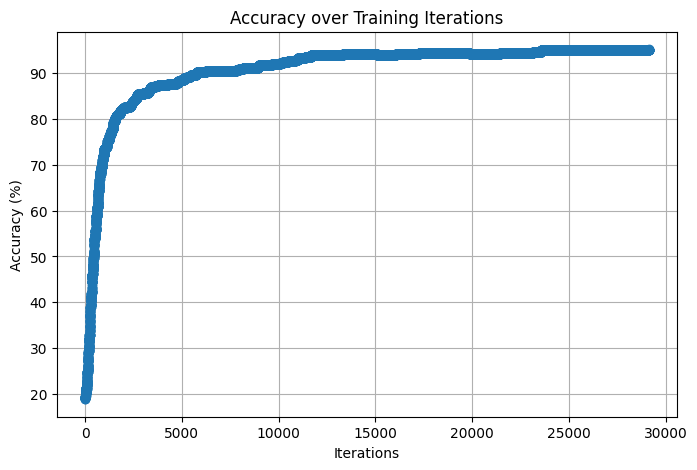

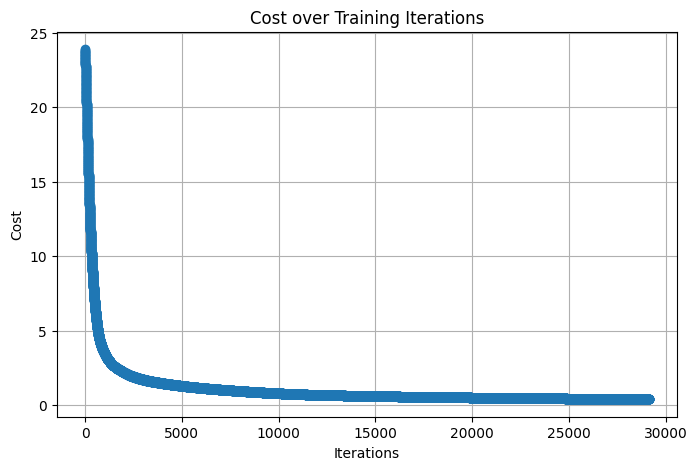

In [13]:
# Initialize weights randomly with larger values
weights = np.random.randn(X_train.shape[1]) * 10
bias = np.random.randn() * 10
# Set the learning rate for gradient descent
learning_rate = 0.01
# Train the model using the training data
weights, bias, iterations, costs, accuracies = train(weights, bias, learning_rate, X_train, Y_train)
# Evaluate the model's performance on the test data
test_accuracy = accuracy(weights, bias, X_test, Y_test)
# Print the test accuracy
print(f"\nTest Accuracy: {test_accuracy:.2f}%")
# Plot the accuracy curve over the training iterations
plot_accuracy_curve(iterations, accuracies)
# Plot the cost curve over the training iterations
plot_cost_curve(iterations, costs)